# **Digital Signal and Image Management - E03**<br/>
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

prof. Simone Bianco,
dr. Marco Buzzelli

In [88]:
import numpy as np
from matplotlib import pyplot as plt

# Image management
from skimage import io # Input/output
from skimage import transform # Geometric transformations (e.g. resize)
from skimage import filters # Local processing
from skimage import color # Change of color space

In [89]:
# Set visualization size for figures (notebook only)
plt.rcParams['figure.figsize'] = [15,5] # width, height

## Image loading and visualization

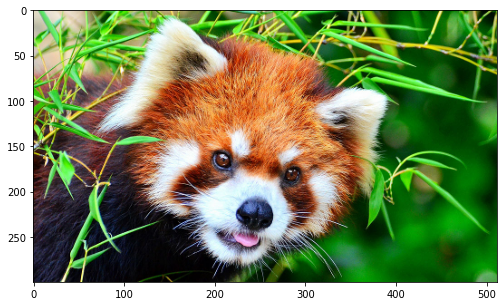

In [90]:
# Import image with skimage, and visualize with matplotlib
im = io.imread('redpanda.png')
plt.imshow(im); plt.show()

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread

**Note:**
* We are using ``skimage`` because it is lightweight, and because it automatically imports the data as a numpy array.
* 
Other possibilities are Pillow (PIL), and OpenCV. We might use them in future excercises:
  * ``# Pillow``<br/>
``!conda install pillow``<br/>
``from PIL import Image``<br/>
``im = Image.open('redpanda.png')``<br/>
``im = np.asarray(im) # Needs explicit conversion into numpy array``<br/>
  * ``# OpenCV``<br/>
``!pip install opencv-python``<br/>
``import cv2 as cv``<br/>
``im = cv.imread('redpanda.png')``<br/>
``im = im[::-1:-1:0] # Needs a change in the channel order (BGR -> RGB)``

In [92]:
# Class and data type
print(type(im))
print(im.dtype)

<class 'numpy.ndarray'>
uint8


**Note:**
* Depending on the current version of ``scikit-image``, the class could be either ``numpy.ndarray``, or ``imageio.core.utils.Array``.
  * The second case inherits all attributes and methods from the first one.
* When loading an image, always check the data type. It can be either of these two:
  * `uint8`: integer values between 0 and 255.
  * `float64`: floating point values between 0 and 1.
  * Some operations work in both representations, others don't (e.g. gamma correction)

In [93]:
# Image size
im.shape

(300, 512, 4)

300 rows (height)

512 columns (width)

4 channels: Red, Green, Blue

**Note:**
* The alpha channel is used to encode transparency/opacity:
  * 1 means that the pixel is completely covering the background
  * 0 means that the RGB color of the pixel is irrelevant, as only the background will be shown
  * Any value in between encodes a weighted average between the color of the background and the color of the pixel
* It is only supported by certain image formats (e.g. png), and it is optional anyway.
* In many applications we will need to work only on one channel.
  * One way to do this, is to convert the image into grayscale (see next).

### Grayscale import

In [94]:
im = io.imread('redpanda.png', as_gray=True)

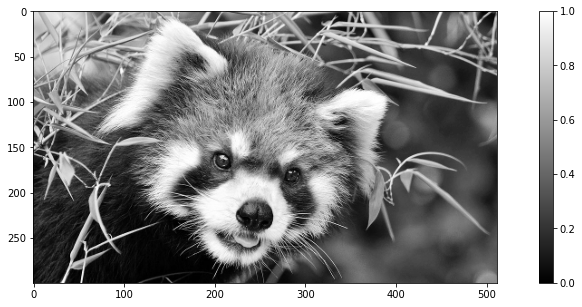

In [95]:
plt.imshow(im, cmap='gray'); plt.clim(0,1); plt.colorbar(); plt.show()

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html<br/>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.clim.html<br/>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html<br/>

In [96]:
# Image size
im.shape

(300, 512)

In [97]:
# Class and data type
print(type(im))
print(im.dtype)

<class 'numpy.ndarray'>
float64


**Note:**
* The grayscale is a linear combination (weighted mean) between the three channels R, G, and B, where green has the largest weight.
* Loading an image with ``skimage`` using ``as_gray=True`` also transorms the data into a floating point representation with values between 0 and 1.
* Other libraries can load an image as grayscale as well, by issuing the following commands:
  * ``# Pillow``<br/>
``im = Image.open('images/redpanda.png').convert('L')``<br/>
https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
  * ``# OpenCV``<br/>
``im = cv.imread('images/redpanda.png', 0)``
* The parameter `cmap='gray'` is used to specify the color map used for visualizing single-channel images.
  * In this case (`dtype=float64`), it shows the lowest value as black and the highest as white.
  * By using `plt.clim(0,1)` we visualize as black al pixels with value 0 (and below), and we visualize as white all pixels with value 1 (and above).

## Punctual processing

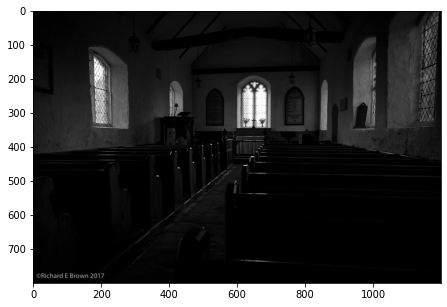

In [98]:
# Loading a dark image
im = io.imread('church.jpg', as_gray=True)
plt.imshow(im, cmap='gray'); plt.clim(0,1); plt.show()

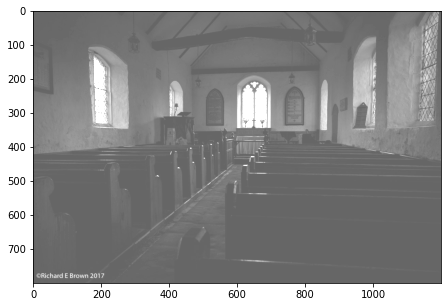

In [99]:
# Brightening the image using the sum
bright_sum = 0.4 #@param {type:"slider", min:-1, max:1, step:0.1}
plt.imshow(im+bright_sum, cmap='gray'); plt.clim(0,1); plt.show()

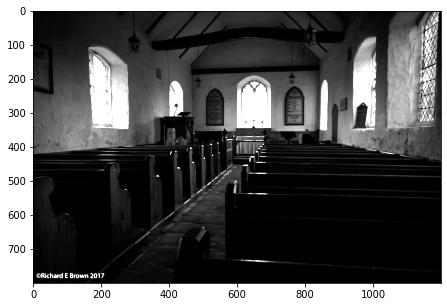

In [100]:
# Brightening the image using the multiplication
bright_mul = 3 #@param {type:"slider", min:0, max:5, step:0.1}
plt.imshow(im*bright_mul, cmap='gray'); plt.clim(0,1); plt.show()

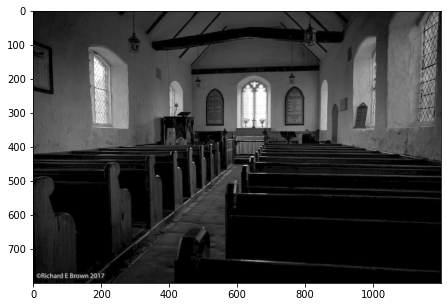

In [101]:
# Brightening the image using the power (a.k.a. Gamma)
bright_pow = 0.5 #@param {type:"slider", min:0.1, max:2, step:0.1}
plt.imshow(im**bright_pow, cmap='gray'); plt.clim(0,1); plt.show()

https://colab.research.google.com/notebooks/forms.ipynb

**Note:**
* Different curves, representing different brightening operations: https://www.desmos.com/calculator/tqm5rqmzh8:
  * y = x {0<x<1}
  * y = min(x+0.3, 1) {0<x<1}
  * y = min(x*1.3, 1) {0<x<1}
  * y = min(x^0.4, 1) {0<x<1}
* Of all these operations, the gamma (power) is the only one that preserves the pure blacks and pure whites, thus avoiding saturated or washed-out pixels.
* The gamma is also the only operation that works as expected *only* when the inputs are in the interval 0÷1.
  * If the image is encoded as 0÷255 values:
    * The blacks and whites will not be preserved.
    * Parts of the image will be made darker, parts brighter.
    * You can remove the `{0<x<1}` constraints from the above desmos visualizations to see the effect.

In [102]:
# Let's consolidate the gamma correction for all subsequent experiments
im = im ** 0.5

## Image manipulation

### Rescaling / resizing

In [103]:
# Initial resolution
im.shape

(800, 1200)

In [104]:
# Computing the new image size (20%)
new_shape = (int(im.shape[0]*0.2), int(im.shape[1]*0.2))

In [105]:
new_shape

(160, 240)

In [106]:
# Resize
im_small = transform.resize(im, new_shape)

In [107]:
# Final resolution
im_small.shape

(160, 240)

https://scikit-image.org/docs/dev/api/skimage.transform#skimage.transform.resize

**Note:**
* We have computed the new resolution as 20\% for each side of the original image

### Overlap

In [108]:
# Create a copy of the full-resolution image
im_over = im.copy()

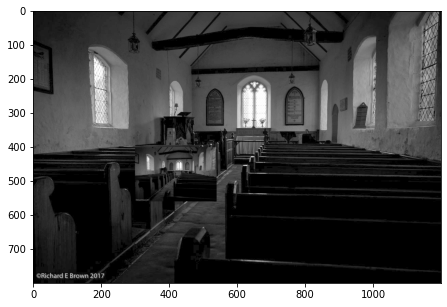

In [109]:
# Paste the small-resolution image over the full-resolution one
im_over[400:400+im_small.shape[0], 300:300+im_small.shape[1]] = im_small
plt.imshow(im_over, cmap='gray'); plt.show()

**Note:**
* We have replaced the pixels in the larger image, starting from row 400 and column 300, inserting pixels from the smaller image
* This simple operation can come in handy in many future applications

## Local processing (filtering)



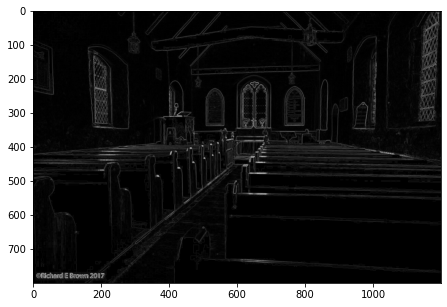

In [110]:
# Linear filtering to extract the edges
im_edge = filters.sobel(im)
plt.imshow(im_edge, cmap='gray'); plt.show()

https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel

**Note:**
* The Sobel filter is an edge detector: it produces a "map" with high values where the original image has sharp changes from bright to dark pixels, and lower values elsewhere.
* ``filters.sobel()`` directly computes the edge magnitude in all directions.
* By definition, the sobel filter is related to one specific direction.
* If needed, the two underlying components (horizontal and vertical) can be individually computed with a variety of alternatives:
  * https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_h and<br/>https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_v
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html<br/>(by properly definining a custom filter)

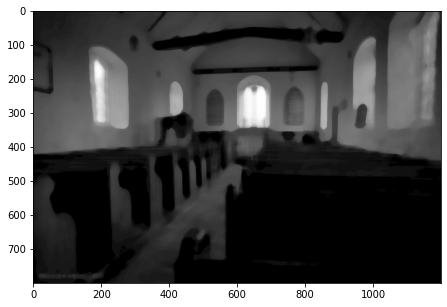

In [111]:
# Ranking filter
se = np.ones((21,21)) # Structural element
im_order = filters.rank.percentile(im, se, p0=0.5)
plt.imshow(im_order, cmap='gray'); plt.show()

https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.percentile

**Note:**
* The 50th percentile (``p0=0.5``) corresponds to extracting the median value from the neighborhood of each pixel:
* ``im_median = filters.median(im, selem=se)``<br/>
https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.median

## Color management

In [112]:
# Re-open the red panda image
im = io.imread('redpanda.png')

### RGB (Red/Green/Blue)

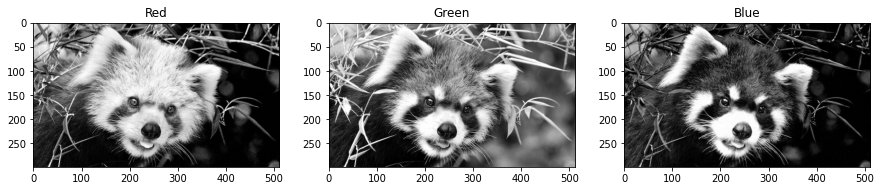

In [113]:
# Visualization of R,G,B channels
plt.subplot(1,3,1); plt.imshow(im[:,:,0], cmap='gray'); plt.title('Red')
plt.subplot(1,3,2); plt.imshow(im[:,:,1], cmap='gray'); plt.title('Green')
plt.subplot(1,3,3); plt.imshow(im[:,:,2], cmap='gray'); plt.title('Blue')
plt.show()

**Note:**
* Each channel encodes the amount of red, green, or blue, for each pixel.
* Note for example:
  * High values for the green channel on the leaves
  * High values for the red channel on the forehead
  * High values on all channels for white areas, and low values on all channels for black areas

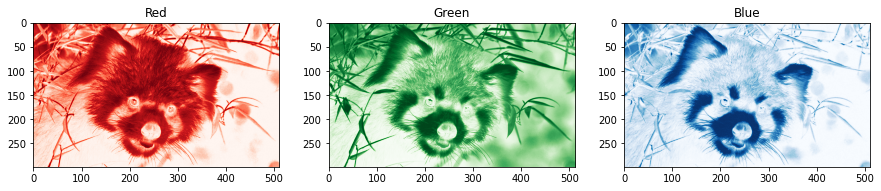

In [114]:
# Visualization of R,G,B channels using color maps
plt.subplot(1,3,1); plt.imshow(im[:,:,0], cmap='Reds'); plt.title('Red')
plt.subplot(1,3,2); plt.imshow(im[:,:,1], cmap='Greens'); plt.title('Green')
plt.subplot(1,3,3); plt.imshow(im[:,:,2], cmap='Blues'); plt.title('Blue')
plt.show()

**Note**:
* This is merely an alternative visualization.
* The data is still composed of three bidimensional matrices, encoding the amount of each "primary color".

### HSV (Hue / Saturation / Value)

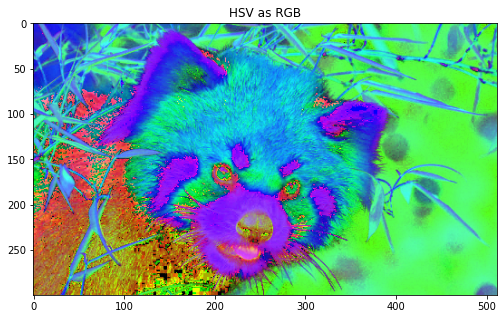

In [115]:
# Conversion from RGB to HSV
im_hsv = color.rgb2hsv(im[:,:,0:3])
plt.imshow(im_hsv); plt.title('HSV as RGB'); plt.show()

https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2hsv

**Note:**
* This visualization is hardly useful:<br/>
We are interpreting the numbers that encode the hue, as if they encode the red. The saturation as green, and the "brightness" value as blue.
* It is more appropriate to visualize each channel independently.

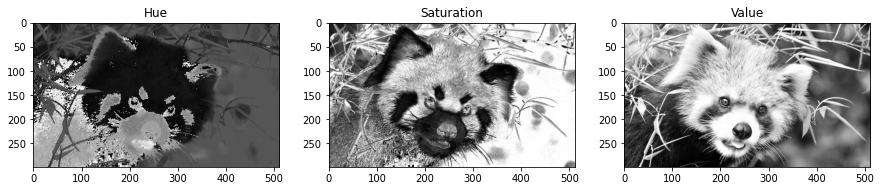

In [116]:
# Independent visualization of H,S,V channels
plt.subplot(1,3,1); plt.imshow(im_hsv[:,:,0], cmap='gray'); plt.title('Hue')
plt.subplot(1,3,2); plt.imshow(im_hsv[:,:,1], cmap='gray'); plt.title('Saturation')
plt.subplot(1,3,3); plt.imshow(im_hsv[:,:,2], cmap='gray'); plt.title('Value')
plt.show()

**Note:**
* Value: this is correlated to the concept of "brightness" (although brightness has its own definition).<br/>
It is different from the results obtained with the RGB-to-grayscale conversion, but conceptually similar.
* Saturation: how much a given pixel is close to a "pure" color.<br/>
A low value represents greys (including black and white). A high value represents a "brilliant" color.
* Hue: regardless of saturation and value, this identifies the type of color on the color wheel.<br/>
It is represented in degrees on a circle, so colors close to 0 are similar to colors close to 360 (or whatever it is the maximum value used for encoding).<br/>
Also note that the Hue value has no meaning when saturation=0.


### YCbCr (Luma / Chroma blue-yellow / Chroma red-green)

https://en.wikipedia.org/wiki/YCbCr#CbCr

* YCbCr is another color space that separates a brightness-like component (Luma) from the color components (Chroma).
* The colors are encoded as:
  * Cb: a high value indicates blue, a low value indicates its opposite yellow.
  * Cr: a high value indicates red, a low value indicates its opposite red.
* It is used, for example, in the JPEG compression.
  * Note that this is transparent to us: when we import a jpg image using `imread`, this gets decompressed and converted in RGB automatically.

#### Assignment: image compression based on color representation

* Our human visual system is more sensitive to details/changes in brightness, and much less sensitive to details/changes in color.
* This is at the core of many compression algorithms:
  * They reduce the amount of information that encodes color
  * This translates to a smaller file size
  * There is little negative impact on the final quality of the image
* For the assignement, we will use Gaussian blur as a technique to reduce the amount of information.
  * This is not what JPEG does, and it does not necessarily translates to a smaller file size, but it easily illustrates the concept.
  * For the purpose of the assignement, you are not expected to save the images and evaluate the file size.

**Approach**:

1. Choose a new image, different from the ones used in this notebook
2. Convert it into YCbCr color space
3. Blur Cb and Cr channels using a wide gaussian filter
4. Visualize each channel of the YCbCr, and the rebuilt resulting RGB image
5. Blur only the Y channel (and keep the original Cb and Cr)
6. Visualize each channel of the YCbCr, and the rebuilt resulting RGB image

You *must* test (and show) different sizes of the gaussian filter to appreciate the degree of tolerance of the human eye to color compression.

Hint:
* If you obtain unexpected results, pay attention to the `multichannel` parameter in the gaussian transformation, and to the data type.

In [117]:
im_rgb_temp = io.imread('gattini.jpg')
im_rgb_temp2 = im_rgb_temp[50:1200,0:850,:]     # ritaglio l'immagine per selezionare parte interessata
from skimage.transform import resize    
im_rgb = resize(im_rgb_temp2, (im_rgb_temp.shape[0] // 4, im_rgb_temp.shape[1] // 4), anti_aliasing=True)   # resize

Eseguo un resize dell'immagine per rendere più semplici computazionalmente le operazioni di filtraggio e per rendere più leggibili i risultati: la visualizzazione di una immagine con alta risoluzione all'interno del notebook non si differenzia molto da una con risoluzione un po' più bassa. Sull'immagine a risoluzione ridotta sono inoltre apprezzabili maggiormente le operazioni di filtraggio, poichè a parità di dimensione di filtro (e quindi di grandezza della sigma del filtro gaussiano) operano su una porzione di immagine più grande. L'effetto è che si sfoca di più l'immagine e si ha minor complessità computazionale.

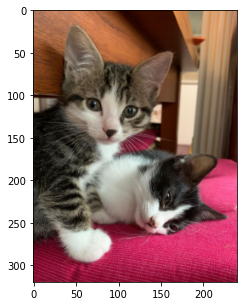

In [118]:
plt.imshow(im_rgb); plt.show()

In [119]:
# Conversione da RGB a YCbCr
im_ycbcr = color.rgb2ycbcr(im_rgb[:,:,:])

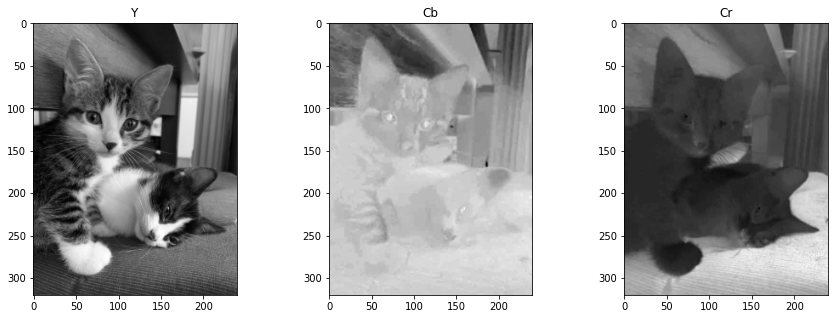

In [120]:
# Visualizzazione indipendente dei canali Y,Cb,Cr
plt.subplot(1,3,1); plt.imshow(im_ycbcr[:,:,0], cmap='gray'); plt.title('Y')
plt.subplot(1,3,2); plt.imshow(im_ycbcr[:,:,1], cmap='gray'); plt.title('Cb')
plt.subplot(1,3,3); plt.imshow(im_ycbcr[:,:,2], cmap='gray'); plt.title('Cr')
plt.show()

Nel primo subplot abbiamo la luminanza, che sostanzialmente corrisponde all'immagine in bianco e nero dell'immagine di partenza. Nel secondo canale possiamo notare invece come la componente giallo/marrone del tavolo sia rappresentata con valori bassi, poichè è all'opposto del blu.
Il cuscino viola invece ha valori alti sia nel canale Cb che nel canale Cr proprio perchè il viola è l'unione del blu e del rosso

In [121]:
def compress_CbCr(im_ycbcr, sigma):
  filtered_im_ycbcr = np.copy(im_ycbcr)     # creo copia dell'immagine per non applicare i ris all'immagine passata come par
  filtered_im_ycbcr[:,:,1] = filters.gaussian(im_ycbcr[:,:,1], sigma=sigma)     # applico filtro gaussiano su canale Cb
  filtered_im_ycbcr[:,:,2] = filters.gaussian(im_ycbcr[:,:,2], sigma=sigma)     # applico filtro gaussiano su canale Cr
  return filtered_im_ycbcr

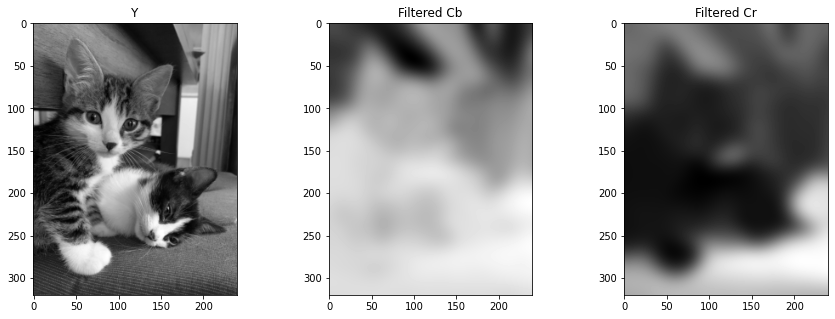

In [122]:
im_cBlur_ycbcr = compress_CbCr(im_ycbcr, 10)      # applico il filtro gaussiano su Cb e Cr
plt.subplot(1,3,1); plt.imshow(im_cBlur_ycbcr[:,:,0], cmap='gray'); plt.title('Y')
plt.subplot(1,3,2); plt.imshow(im_cBlur_ycbcr[:,:,1], cmap='gray'); plt.title('Filtered Cb')
plt.subplot(1,3,3); plt.imshow(im_cBlur_ycbcr[:,:,2], cmap='gray'); plt.title('Filtered Cr')
plt.show()

Si noti come i canali Cb e Cr siano stati sfocati dal filtro gaussiano.

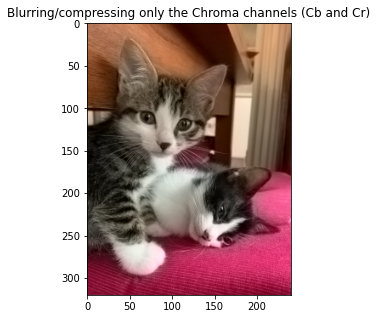

In [123]:
im_cBlur_rgb = color.ycbcr2rgb(im_cBlur_ycbcr)      # riporto l'immagine in rgb per plottarla
plt.title('Blurring/compressing only the Chroma channels (Cb and Cr)')
plt.imshow(im_cBlur_rgb)

Il risultato con sigma=10 ha una qualità dell'immagine molto simile all'originale, si nota solamente poco del viola del cuscino intaccare la parte più in basso dei gatti. L'immagine risulta inoltre leggermente sbiadita.

Si noti inoltre il warning del plot: riportando nello spazio RGB l'immagine dopo aver filtrato Cb e Cr, non è assicurato che un pixel sia esattamente nel range tra 0 e 1. 

In [124]:
print(np.max(im_cBlur_rgb))
print(np.min(im_cBlur_rgb))

1.1489431513217625
-0.08346723837670049


Ciò obbliga la funzione che plotta l'immagine a clippare i valori. Il motivo per cui ciò avviene è che le equazioni che descrivono la trasformazione da YcbCr a RGB ora devono tenere conto dei valori alterati dal filtro e quindi fissato un pixel nei tre canali, può succedere che i valori di Cb e Cr corrispondenti siano diventati "incompatibili" con il valore Y e questo fa si che la trasformazione faccia uscire la rappresentazione RGB del pixel dal range [0:1] X [0:1] X [0:1].

Utilizziamo ora diversi valori di sigma:

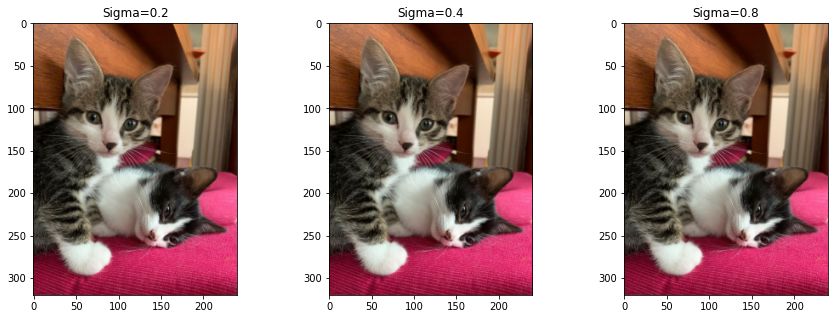

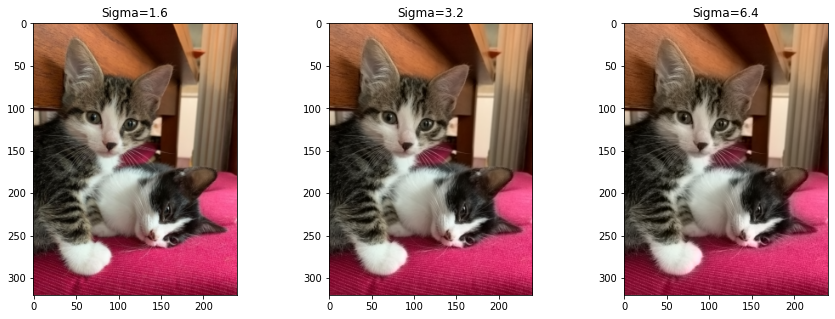

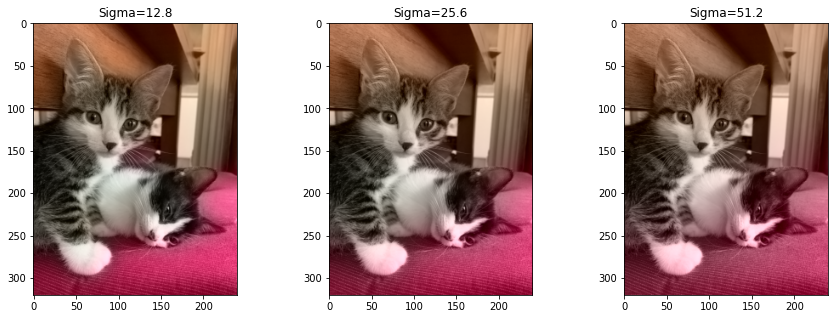

<Figure size 1080x360 with 0 Axes>

In [125]:
sigma = 0.2
for i in range(1,4):
  for j in range(1,4):
    plt.subplot(1,3,j); plt.imshow(color.ycbcr2rgb(compress_CbCr(im_ycbcr, sigma))); plt.title('Sigma='+ str(sigma))
    if (j%3 == 0) :
      plt.figure()
    sigma = sigma*2

La tendenza osservata precedentemente diventa sempre più accentuata con valori di sigma maggiori. Ad occhio l'immagine sembra uguale all'originale con sigma fino a 6.4, risulta ancora accettabile con sigma=12.8, mentre con sigma 25.6 e 51.2 è evidente lo sbiadimento dei colori con effetto sfumato verso zone di immagine adiacenti (esempio il cuscino e la parte in basso dei gatti)

**Note:**
* Despite the strong reduction in the details of the Cb and Cr chroma channels, the image is still relatively pleasing to the eye.

Analizziamo ora cosa succede applicando il filtro gaussiano solamente al canale Y:

In [126]:
def compress_Y(im_ycbcr, sigma):
  filtered_im_ycbcr = np.copy(im_ycbcr)     # creo copia dell'immagine per non applicare i ris all'immagine passata come par
  filtered_im_ycbcr[:,:,0] = filters.gaussian(im_ycbcr[:,:,0], sigma=sigma)     # applico filtro gaussiano su canale Y
  return filtered_im_ycbcr

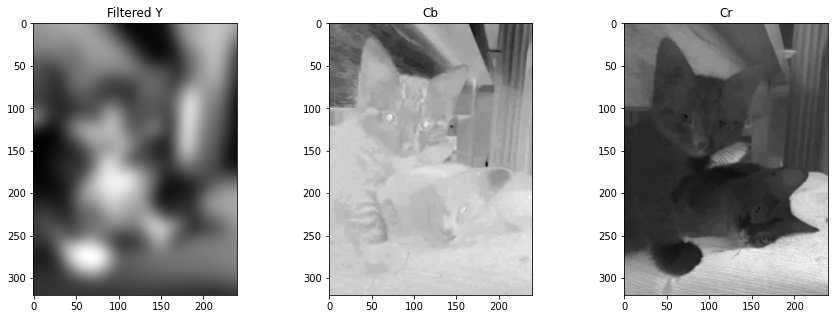

In [127]:
im_yBlur_ycbcr = compress_Y(im_ycbcr, 10)     # applico il filtro gaussiano su Y
plt.subplot(1,3,1); plt.imshow(im_yBlur_ycbcr[:,:,0], cmap='gray'); plt.title('Filtered Y')
plt.subplot(1,3,2); plt.imshow(im_yBlur_ycbcr[:,:,1], cmap='gray'); plt.title('Cb')
plt.subplot(1,3,3); plt.imshow(im_yBlur_ycbcr[:,:,2], cmap='gray'); plt.title('Cr')
plt.show()

Si noti come il canale Y sia stato sfocato dal filtro gaussiano.

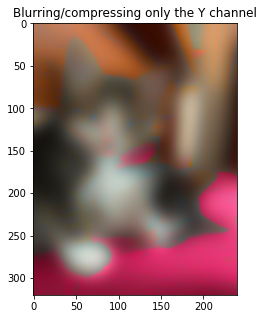

In [128]:
im_yBlur_rgb = color.ycbcr2rgb(im_yBlur_ycbcr)      # riporto l'immagine in rgb per plottarla
plt.title('Blurring/compressing only the Y channel')
plt.imshow(im_yBlur_rgb)

L'immagine con Y filtrato con sigma=10 risulta già molto sfocata e quindi di qualità estremamente inferiore rispetto all'immagine con Cb e Cr filtrati, anche considerando valori di sigma molto maggiori.

Utilizziamo ora diversi valori di sigma:

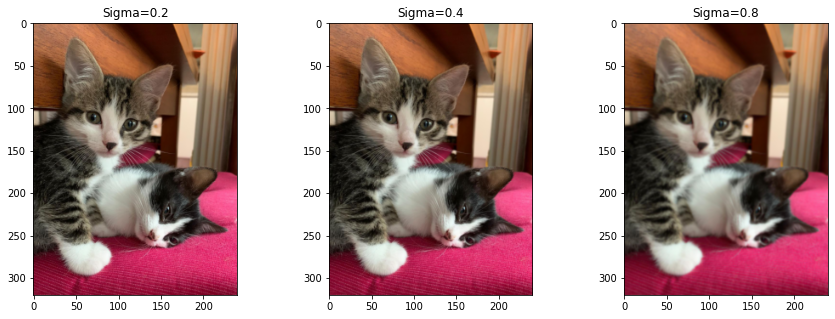

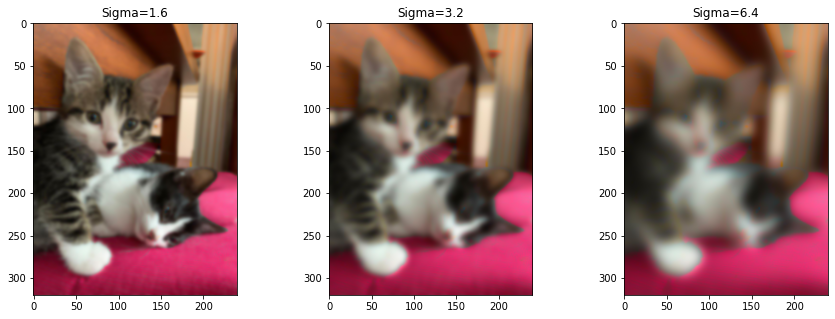

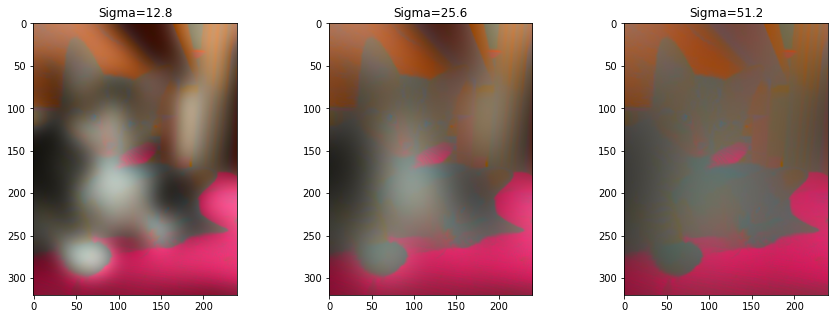

<Figure size 1080x360 with 0 Axes>

In [129]:
sigma = 0.2
for i in range(1,4):
  for j in range(1,4):
    plt.subplot(1,3,j); plt.imshow(color.ycbcr2rgb(compress_Y(im_ycbcr, sigma))); plt.title('Sigma='+ str(sigma))
    if (j%3 == 0) :
      plt.figure()
    sigma = sigma*2

L'immagine perde di qualità già con sigma=0.8 e 1.6. Risulta molto sfocata con sigma 3.2 e 6.4 e risulta illeggibile con sigma maggiore di 12.8. Possiamo quindi facilmente concludere che il canale della luminanza sia molto più importante al nostro occhio rispetto ai canali di crominanza.

**Note:**
* Despite the fact that only one channel has been "compressed" (compared to two channels in the previous case), the reconstructed RGB image appears highly blurred and unnatural.